In [13]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%%writefile ../src/cad_agent_from_scratch/coding_state.py

"""
State definitions for the Agentic CAD Coding workflow.

This state is used ONLY for the coding stage:
- Manager → Worker(s) → Synthesizer
"""

import operator
from typing_extensions import TypedDict, Annotated, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class CodingState(TypedDict):
    """
    Global state for the OpenSCAD code generation workflow.
    """

    # Messages exchanged with the coding manager (planning-to-coding reasoning)
    manager_messages: Annotated[Sequence[BaseMessage], add_messages]

    # Approved human-readable design plan (text only)
    design_plan: str

    # Parsed intent from intention clarification (read-only context)
    parsed_intent: dict

    # OpenSCAD code blocks produced by worker coder(s)
    # - Single element for part-level objects
    # - Multiple elements for assemblies
    worker_code_blocks: Annotated[list[str], operator.add]

    # Final synthesized OpenSCAD code (single valid file)
    final_openscad_code: str


Overwriting ../src/cad_agent_from_scratch/coding_state.py


In [15]:
%%writefile ../src/cad_agent_from_scratch/coding_workflow.py

"""
Agentic CAD Coding Workflow

This module implements the coding stage of the CAD Agent:
- Coding Manager (task delegation + execution strategy inference)
- Worker Coder(s) (OpenSCAD generation)
- Synthesizer (final authority)

Scope:
- Generation + synthesis only
- No MCP execution
- No evaluation
"""

import asyncio
from typing import List

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from cad_agent_from_scratch.coding_state import CodingState
from cad_agent_from_scratch.prompts import (
    CODER_MANAGER_PROMPT,
    CODER_WORKER_PROMPT,
    CODER_SYNTHESIZER_PROMPT,
)
from cad_agent_from_scratch.utils import think_tool

# ---------------------------------------------------------------------
# Models
# ---------------------------------------------------------------------

manager_model = init_chat_model(model="gpt-4.1")
worker_model = init_chat_model(model="gpt-4.1-mini")
synthesizer_model = init_chat_model(model="gpt-4.1")

# Bind think_tool ONLY to the manager
manager_model_with_tools = manager_model.bind_tools([think_tool])

# ---------------------------------------------------------------------
# Worker logic (called by manager, NOT a graph node)
# ---------------------------------------------------------------------

async def run_worker(task_description: str) -> str:
    """
    Generate OpenSCAD code for a single part or feature.
    """
    messages = [
        SystemMessage(content=CODER_WORKER_PROMPT),
        HumanMessage(content=task_description),
    ]
    response = await worker_model.ainvoke(messages)
    return response.content


# ---------------------------------------------------------------------
# Coding Manager node
# ---------------------------------------------------------------------

async def coder_manager(state: CodingState) -> Command:
    """
    Infer an execution strategy from the design plan,
    delegate coding tasks to worker(s), and collect their outputs.
    """

    messages = [
        SystemMessage(content=CODER_MANAGER_PROMPT),
        HumanMessage(
            content=(
                "You are deciding how to execute a CAD coding task.\n\n"
                "Before delegating, reflect on:\n"
                "- Whether the design is a single continuous solid or an assembly\n"
                "- Whether multiple coders are required or would add unnecessary coordination risk\n"
                "- The appropriate granularity for code generation\n\n"
                "Use think_tool to record your reasoning before deciding.\n\n"
                f"Design Plan:\n{state['design_plan']}"
            )
        ),
    ]

    # Manager reasons (may call think_tool)
    manager_response = await manager_model_with_tools.ainvoke(messages)

    # Execute think_tool if it was called
    if manager_response.tool_calls:
        for tool_call in manager_response.tool_calls:
            if tool_call["name"] == "think_tool":
                think_tool.invoke(tool_call["args"])

    # -----------------------------------------------------------------
    # Execution strategy inference (semantic, not keyword-based)
    # -----------------------------------------------------------------

    plan_text = state["design_plan"].lower()

    # Conservative, semantics-first interpretation
    is_single_solid = all(
        phrase not in plan_text
        for phrase in [
            "multiple parts",
            "assembled",
            "separate components",
            "joined",
            "attached",
            "detachable",
        ]
    )

    if is_single_solid:
        worker_tasks = [
            "Generate complete OpenSCAD code for this single solid object based strictly on the design plan."
        ]
    else:
        # Assembly case (still conservative, extensible later)
        worker_tasks = [
            "Generate OpenSCAD code for the first distinct part described in the design plan.",
            "Generate OpenSCAD code for the second distinct part described in the design plan.",
        ]

    # Run workers (parallel if more than one)
    worker_outputs: List[str] = await asyncio.gather(
        *[run_worker(task) for task in worker_tasks]
    )

    return Command(
        update={
            "manager_messages": [manager_response],
            "worker_code_blocks": worker_outputs,
        },
        goto="coder_synthesizer",
    )


# ---------------------------------------------------------------------
# Synthesizer node
# ---------------------------------------------------------------------

async def coder_synthesizer(state: CodingState) -> Command:
    """
    Combine worker-generated OpenSCAD code into a single,
    valid OpenSCAD file. Fix issues if needed.
    """

    worker_code_text = "\n\n".join(state.get("worker_code_blocks", []))

    combined_input = f"""
Design Plan:
{state["design_plan"]}

Worker Code Blocks:
{worker_code_text}
"""

    messages = [
        SystemMessage(content=CODER_SYNTHESIZER_PROMPT),
        HumanMessage(content=combined_input),
    ]

    response = await synthesizer_model.ainvoke(messages)

    return Command(
        update={
            "final_openscad_code": response.content
        },
        goto=END,
    )


# ---------------------------------------------------------------------
# Workflow construction
# ---------------------------------------------------------------------

builder = StateGraph(CodingState)

builder.add_node("coder_manager", coder_manager)
builder.add_node("coder_synthesizer", coder_synthesizer)

builder.add_edge(START, "coder_manager")
builder.add_edge("coder_manager", "coder_synthesizer")

coding_workflow = builder.compile()


Overwriting ../src/cad_agent_from_scratch/coding_workflow.py


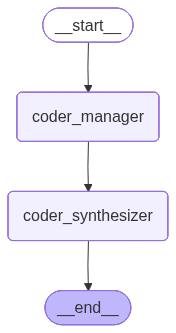

In [16]:
from langgraph.checkpoint.memory import InMemorySaver
from cad_agent_from_scratch.coding_workflow import builder
from IPython.display import Image, display

checkpointer = InMemorySaver()

coding_agent = builder.compile(
    checkpointer=checkpointer
)

display(
    Image(coding_agent.get_graph(xray=True).draw_mermaid_png())
)


In [18]:
from langchain_core.messages import HumanMessage
from cad_agent_from_scratch.coding_workflow import coding_workflow

thread = {"configurable": {"thread_id": "15"}}

# ---- approved plan from planning step ----
approved_design_plan = """
1. Single solid cubic body forming the entire object.
2. All faces are equal in size, defining a uniform cube.
3. Each edge has an approximate length of 50 units.
4. The object is static with no internal cavities or additional features.
"""

coding_state = {
    # Manager reasoning messages (start empty)
    "manager_messages": [],

    # Approved plan (AUTHORITATIVE)
    "design_plan": approved_design_plan,

    # Parsed intent (read-only context)
    "parsed_intent": {
        "object_name": "cube",
        "components": ["cube"],
        "dimensions": {"side_length": "50 units"},
        "configuration": "solid",
        "assumptions": None,
    },

    # Worker outputs (empty at start)
    "worker_code_blocks": [],

    # Final output placeholder
    "final_openscad_code": "",
}

# ---- run coding workflow ----
result = await coding_agent.ainvoke(coding_state, config=thread)

print("✅ FINAL OPENSCAD CODE:")
print(result["final_openscad_code"])


✅ FINAL OPENSCAD CODE:
cube([50,50,50], center=true);
